In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error
%matplotlib inline 

# MLL Results

In [55]:
path = '~/sims_n_results/simupdates_aug2020/'
uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
mll = {}
for i, unc_job in enumerate(job_dirs):
    mll['unc' + str(i)] = pd.read_csv(path + 'train29/' + unc_job + '/' + unc_job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll.keys()

dict_keys(['unc0', 'unc1', 'unc2', 'unc3'])

In [56]:
mll['unc1'].columns

Index(['sim_idx', 'ReactorType', 'CoolingTime', 'Enrichment', 'Burnup',
       'OrigenReactor', 'AvgPowerDensity', 'ModDensity', 'UiWeight',
       'pred_idx', 'pred_ReactorType', 'pred_CoolingTime', 'pred_Enrichment',
       'pred_Burnup', 'pred_OrigenReactor', 'AvgPowerDensity.1',
       'ModDensity.1', 'UiWeight.1', 'MaxLogLL', 'MaxLLUnc', '2ndMaxLogLL',
       '2ndMaxLLUnc', 'CDF_LogLL_0.9998', 'CDF_LLUnc_0.9998',
       'CDF_LogLL_0.9988', 'CDF_LLUnc_0.9988', 'CDF_LogLL_0.95',
       'CDF_LLUnc_0.95', 'CDF_LogLL_0.9', 'CDF_LLUnc_0.9', 'CDF_LogLL_0.5',
       'CDF_LLUnc_0.5', 'CDF_LogLL_0.1', 'CDF_LLUnc_0.1', 'CDF_LogLL_0.01',
       'CDF_LLUnc_0.01', 'ReactorType_Score', 'CoolingTime_Error',
       'Enrichment_Error', 'Burnup_Error', 'OrigenReactor_Score'],
      dtype='object')

In [57]:
rxtr_mll = []
burn_mll = []
enri_mll = []
cool_mll = []
for i, unc_job in enumerate(uncs):
    rxtr_mll.append(accuracy_score(mll['unc'+str(i)]['ReactorType'], mll['unc'+str(i)]['pred_ReactorType']))
    burn_mll.append(explained_variance_score(mll['unc'+str(i)]['Burnup'], mll['unc'+str(i)]['pred_Burnup']))
    enri_mll.append(explained_variance_score(mll['unc'+str(i)]['Enrichment'], mll['unc'+str(i)]['pred_Enrichment']))
    cool_mll.append(explained_variance_score(mll['unc'+str(i)]['CoolingTime'], mll['unc'+str(i)]['pred_CoolingTime']))

# Plotting

In [58]:
# color dict (use: colors['XColor'])

colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [59]:
learn_path = 'learn29/rand_err/tset'
csv_end = '_nuc29_random_error.csv'
fracs = ['0.1', '0.3', '1.0']
burn_knn = {}
burn_dtr = {}
rxtr_knn = {}
rxtr_dtr = {}
enri_knn = {}
enri_dtr = {}
cool_knn = {}
cool_dtr = {}
for frac in fracs:
    burn_knn['tset'+frac] = pd.read_csv(path + learn_path + frac + '_burnup_knn' + csv_end).drop(columns='Unnamed: 0')
    burn_dtr['tset'+frac] = pd.read_csv(path + learn_path + frac + '_burnup_dtree' + csv_end).drop(columns='Unnamed: 0')
    rxtr_knn['tset'+frac] = pd.read_csv(path + learn_path + frac + '_reactor_knn' + csv_end).drop(columns='Unnamed: 0')
    rxtr_dtr['tset'+frac] = pd.read_csv(path + learn_path + frac + '_reactor_dtree' + csv_end).drop(columns='Unnamed: 0')
    enri_knn['tset'+frac] = pd.read_csv(path + learn_path + frac + '_enrichment_knn' + csv_end).drop(columns='Unnamed: 0')
    enri_dtr['tset'+frac] = pd.read_csv(path + learn_path + frac + '_enrichment_dtree' + csv_end).drop(columns='Unnamed: 0')
    cool_knn['tset'+frac] = pd.read_csv(path + learn_path + frac + '_cooling_knn' + csv_end).drop(columns='Unnamed: 0')
    cool_dtr['tset'+frac] = pd.read_csv(path + learn_path + frac + '_cooling_dtree' + csv_end).drop(columns='Unnamed: 0')

In [63]:
def plot_errorcurves(title): 
    plt.clf()    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)   
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Percent Error', fontsize=20, labelpad=15)
    ax.set_ylabel('Score', fontsize=20, labelpad=15)
    
    sv_base = '../plots/randomerror_compare_'
    if 'Reactor' in title:
        knn = rxtr_knn
        dtr = rxtr_dtr
        mll = rxtr_mll
        sv_fig = sv_base + 'rxtr.png'
    elif 'Burnup' in title:
        knn = burn_knn
        dtr = burn_dtr
        mll = burn_mll
        sv_fig = sv_base + 'burn.png'
    elif 'Enrichment' in title:
        knn = enri_knn
        dtr = enri_dtr
        mll = enri_mll
        sv_fig = sv_base + 'enri.png'
    else:
        knn = cool_knn
        dtr = cool_dtr
        mll = cool_mll
        sv_fig = sv_base + 'cool.png'
    
    ## Scikit Results
    err = burn_knn['tset0.1']['Percent Error']
    tset = ['tset0.1', 'tset0.3', 'tset1.0']
    hue = {'tset0.1' : 'L', 'tset0.3' : 'M', 'tset1.0' : 'D'}
    for t in tset:
        ax.fill_between(err, knn[t]['kNN Score'] - knn[t]['kNN Std'], knn[t]['kNN Score'] + knn[t]['kNN Std'], color = colors[hue[t]+'Brwn'], alpha=0.2)
        ax.fill_between(err, dtr[t]['DTree Score'] - dtr[t]['DTree Std'], dtr[t]['DTree Score'] + dtr[t]['DTree Std'], color = colors[hue[t]+'Teal'], alpha=0.2)
        ax.plot(err, knn[t]['kNN Score'], 'o-', color=colors[hue[t]+'Brwn'], mew=0, ms=5, label='kNN, Set Frac: ' + t[4:])
        ax.plot(err, dtr[t]['DTree Score'], 'o-', color=colors[hue[t]+'Teal'], mew=0, ms=5, label='Dec Tree, Set Frac: ' + t[4:])
    
    ## MLL Results
    unc = [100*x for x in uncs]
    ax.plot(unc, mll, 'o-', color=colors['DPurp'], mew=0, ms=5, label='MLL Calc')
    
    ax.tick_params(labelsize=14)
    ax.legend(loc='best')#'right', bbox_to_anchor=(1.4, 0.5))
    plt.show()
    
    #fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

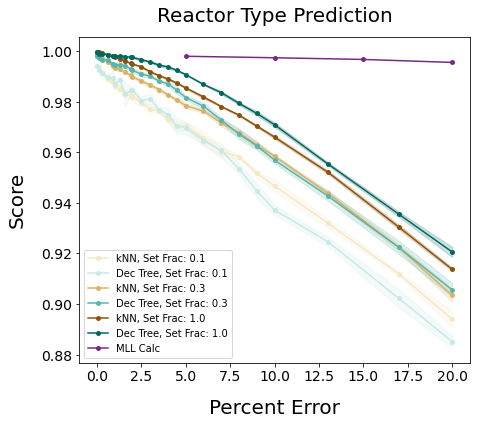

In [64]:
plot_errorcurves('Reactor Type Prediction')

<Figure size 432x288 with 0 Axes>

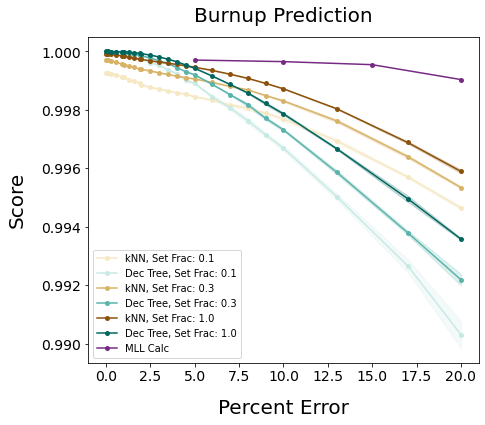

In [65]:
plot_errorcurves('Burnup Prediction')

<Figure size 432x288 with 0 Axes>

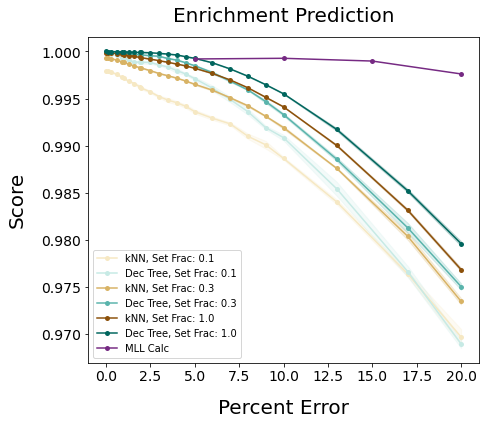

In [66]:
plot_errorcurves('Enrichment Prediction')

<Figure size 432x288 with 0 Axes>

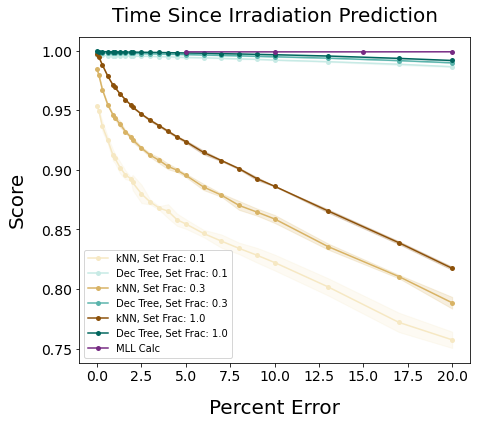

In [67]:
plot_errorcurves('Time Since Irradiation Prediction')

In [ ]:
# next: 15 nuc case, abs error plots too